In [2]:
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
from edward.models import Normal
import seaborn as sns
plt.style.use('ggplot')

In [3]:
def build_toy_dataset(N, w):
  D = len(w)
  x = np.random.normal(0.0, 2.0, size=(N, D))
  y = np.dot(x, w) + np.random.normal(0.0, 0.01, size=N)
  return x, y


ed.set_seed(42)

N = 40  # number of data points
D = 10  # number of features

w_true = np.random.randn(D) * 0.5
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

In [4]:
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))

In [5]:
qw = Normal(loc=tf.get_variable("qw/loc", [D]),
            scale=tf.nn.softplus(tf.get_variable("qw/scale", [D])))
qb = Normal(loc=tf.get_variable("qb/loc", [1]),
            scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))

In [6]:
inference = ed.KLqp({w : qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 64.053


In [7]:
#y = Normal(loc=ed.dot(X,w) + b, scale=tf.ones(N))  #y_post = ed.copy(y, {w: qw, b: qb})
y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(N))

In [8]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.0136921
Mean absolute error on test data:
0.111592


In [9]:
def visualise(X_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  b_samples = b.sample(n_samples).eval()
  plt.scatter(X_data[:, 0], y_data)
  plt.ylim([-10, 10])
  inputs = np.linspace(-8, 8, num=400)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

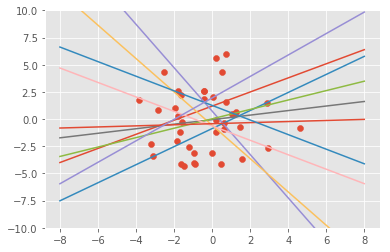

In [10]:
visualise(X_train, y_train, w, b, n_samples=10)

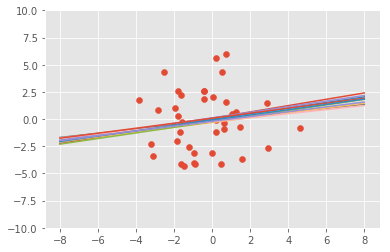

In [11]:
visualise(X_train, y_train, qw, qb, n_samples=10)

Draw samples from y_post

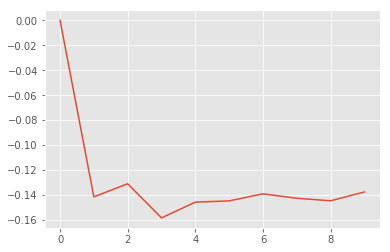

In [12]:
# Convergency test : for different numbers of iteration, calculate the sample mean drawn from predictive posterior distribution.
# As comment by Dustin:  only this line of code is correct: np.mean([sess.run(y_post) for _ in range(50)]), I use this code to draw samples.

sess = ed.get_session()
itr = np.linspace(1, 5000, 10).astype(int)
converge = np.zeros(10)
for t in range(1, 10):
    converge[t]= np.mean([sess.run(y_post, feed_dict={X: X_test}) for _ in range(itr[t])])

plt.plot(converge)

In [13]:
# The plot shows that after large number of iteration, the predictive mean given X_test(40 sets of observation) converge to -0.14
# Compare with mean of y_test, they are not exactly the same but close.
y_test.mean(), converge.mean()

(-0.100222176381247, -0.12846247255802154)

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


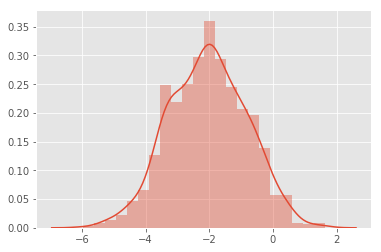

In [14]:
# for each n in samplers[:,n], it gives 1000 sample draws w.r.t the n_th test data in X_test. Below is the density plot of predicted y given the 20th test X.
samplers = np.array([sess.run(y_post, feed_dict={X: X_test}) for _ in range(1000)])
sns.distplot(samplers[:,20], hist=True)

In [53]:
# Predictions compared with test data: y_test.
predict = np.arange(N)
for i in range(N):
    predict[i] = np.mean(samplers[:,i])

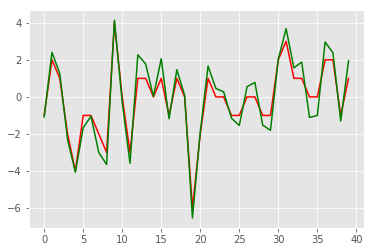

In [54]:
plt.plot(predict, color = 'red')
plt.plot(y_test, color = 'green')

fit GPs

In [17]:
from edward.models import MultivariateNormalTriL
from edward.util import rbf

In [29]:
f = MultivariateNormalTriL(loc=tf.zeros(N), scale_tril=tf.cholesky(rbf(X)))
#w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b_GP = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y_GP = Normal(loc= f + b_GP, scale=tf.ones(N))

In [19]:
qf = Normal(loc=tf.get_variable("qf/loc", [N]), scale=tf.nn.softplus(tf.get_variable("qf/scale", [N])))
qb_GP = Normal(loc=tf.get_variable("qb_GP/loc", [1]), scale=tf.nn.softplus(tf.get_variable("qb_GP/scale", [1])))

In [31]:
inference = ed.KLqp({f: qf, b_GP: qb_GP}, data={X: X_train, y_GP: y_train})
inference.run(n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 8s | Loss: 129.591


In [48]:
# Draw samples from fitted model
y_post_GP = Normal(loc = qf + qb_GP, scale = tf.ones(N))

sess = ed.get_session()
np.mean([sess.run(y_post_GP, feed_dict={X: X_test}) for _ in range(1000)]) # This sample mean is the same as where the above model converge to

-0.14052808

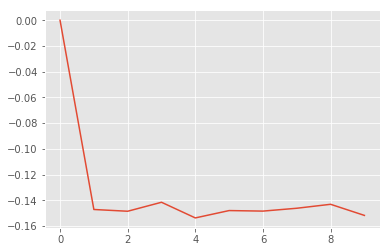

In [55]:
# Convegency check
converge_GP = np.zeros(10)
for t in range(1, 10):
    converge_GP[t]= np.mean([sess.run(y_post_GP, feed_dict={X: X_test}) for _ in range(itr[t])])

plt.plot(converge_GP)

In [51]:
# Prediction check
samplers_GP = np.array([sess.run(y_post_GP, feed_dict={X: X_test}) for _ in range(1000)])
predict_GP = np.arange(N)
predict_GP = predict_GP.astype(float)
for i in range(N):
    predict_GP[i] = np.mean(samplers_GP[:,i])

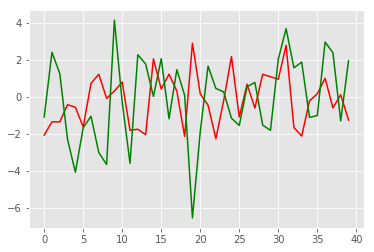

In [52]:
plt.plot(predict_GP, color = 'red')
plt.plot(y_test, color = 'green')   # the result shows terrible prediction, have to figure out why, two approachs suppose to plot similar figure.